# Overview

This is a notebook to calculate the impacts of droughts in the Chitwan Valley on variables of interest to our Nepal Farmer ABM. These include:

- Average crop yield of staple crops (rice, maize, and wheat) and cash crops (e.g. vegetables) in a drought year
- Number of household migrants in a drought year and the year following a drought
- Remittances received by households in a drought year and the year following a drought

It makes use of two main datasets:

- The Chitwan Valley Family Study (CVFS) is a longitudinal survey of farming households in Nepal's Chitwan Valley. Specifically, we use the Agriculture and Migration Survey Data, which surveys 2,255 households for each year from 2006-2016 on questions e.g. the types of crops planted, crop production, number of migrants, and remittances received, among other information. Data can be downloaded here: https://cvfs.isr.umich.edu/data/data-documentation/household-level-data/


- The Standardized Precipitation and Evaporation Index (SPEI), which is a gridded drought index that measures soil moisture balance as a function of precipitation and the calculated evaporation for a grid cell. SPEI is normalized to a historical baseline such that a value of +1 represents soil moisture balance 1 standard deviation above the baseline, and -1 represents a balance of 1 standard deviation below the historical baseline. Here, we use SPEI03, which measures the soil moisture balance for a three month window that ends in the month specified. Data can be downloaded here (click on "Download NC" in bottom-left hand corner): https://spei.csic.es/spei_database/#map_name=spei03#map_position=1415



In [1]:
#Note - A first-time user may need to install/update the packages below, using the commands that are currently commented out
import sys
#!{sys.executable} -m pip install netCDF4
#!{sys.executable} -m pip install numpy --upgrade
#!{sys.executable} -m pip install statsmodels --upgrade
#!{sys.executable} -m pip install xarray

#Import required pacakges
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import scipy
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Importing and Extracting SPEI Data

In [2]:
#Opening downloaded SPEI file using xarray

fp = 'Input_Data/spei03_2021.nc'
spei = xr.open_dataset(fp)


#Extracting data specifically for Chitwan Valley. Note that largest city, Bharatpur, is located at lat = 27.68, lon = 84.43
chitwan_spei = spei.sel(lon=84.25).sel(lat=26.25)

#Extracting Chitwan SPEI data specifically for the time range 2006 - 2016
chitwan_spei_recent = chitwan_spei.sel(time=slice('2006-01-01', '2016-12-31')).squeeze()

chitwan_spei_recent



<xarray.Dataset>
Dimensions:  (time: 132)
Coordinates:
    lon      float64 84.25
    lat      float64 26.25
  * time     (time) datetime64[ns] 2006-01-16 2006-02-15 ... 2016-12-16
Data variables:
    spei     (time) float32 ...
Attributes:
    Title:        Global 3-months SPEI, z-values, 0.5 degree
    Version:      2.6
    Id:           ./outputNcdf/spei03.nc
    Summary:      Global dataset of the Standardized\n\t  Precipitation-Evapo...
    Keywords:     drought, climatology, SPEI, Standardized\n\t  Precipitation...
    Institution:  Consejo Superior de Investigaciones\n\t          Científica...
    Url:          http://sac.csic.es/spei
    Creators:     Santiago Beguería <santiago.begueria@csic.es>\n\t          ...
    Software:     Created in R using the SPEI package\n\t          (https://c...
    Call:         spei.nc(sca=i, inPre=./inputData/cru_ts4.03.1901.2018.pre.d...
    Date:         Wed Feb 12 14:36:52 2020
    Reference:    Beguería S., Vicente-Serrano S., Reig F., Latorre B. (2014)...
    Reference2:   Vicente-Serrano S.M., Beguería S., López-Moreno J.I. (2010)...
    Reference3:   Beguería S., Vicente-Serrano S., Angulo-Martínez M. (2010) ...

# Visualizing SPEI Data

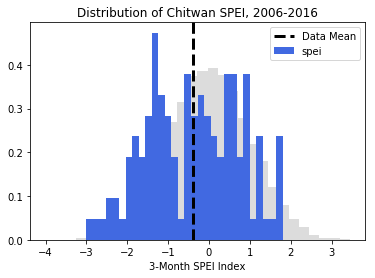

In [3]:
#Creating histogram of SPEI values for Chitwan Valley, 2006-2016
fig, ax = plt.subplots()
data = chitwan_spei_recent['spei']
normal = np.random.normal(loc =0, scale=1, size=10000)

ax.hist(normal, bins=30, color = 'gainsboro', density=True)
ax.hist(data, bins=30, color = 'royalblue', density=True)
plt.axvline(x = data.mean(), lw=3, ls='--', color='black', label='Data Mean')
ax.set_xlabel('3-Month SPEI Index')
plt.title('Distribution of Chitwan SPEI, 2006-2016')
plt.legend()
plt.show()

# Splitting SPEI data into Summer and Winter growing seasons

According to FAO Crop Calendar (https://cropcalendar.apps.fao.org/#/home), the main growing season for rice is from May 15 - Nov. 15, whereas the main growing season for alternate crops (incl. wheat, corn, and other vegetables) is mostly from Nov. 15 - April 15. Here, we will split the SPEI values into these two categories for further analysis.

In [30]:
start_year = 2006
end_year = 2016
summer_months = 7 #Total number of months in each season
winter_months = 6
years = np.arange(start_year, end_year + 1, 1)

summer_spei = {}
winter_spei = {}

for index in range(start_year, end_year):
    summer_start = str(index) + '-05-16'
    summer_end = str(index) + '-11-16'
    winter_start = summer_end
    winter_end = str(index+1) + '-04-16'
    summer_spei[str(index)] = []
    winter_spei[str(index)] = []
    
    summer_spei[str(index)].append(chitwan_spei_recent['spei'].sel(time = slice(summer_start, summer_end)).values)
    winter_spei[str(index)].append(chitwan_spei_recent['spei'].sel(time = slice(winter_start, winter_end)).values)




In [53]:
#Calculating mean SPEI value for summer and winter growing seasons in each year

seasonal_spei = pd.DataFrame(columns=['Year', 'Summer SPEI', 'Winter SPEI'])

seasonal_spei['Year'] = summer_spei.keys()

for count, row in enumerate(seasonal_spei['Year']):
    seasonal_spei['Year'][count] = int(seasonal_spei['Year'][count]) + 57
    seasonal_spei['Summer SPEI'][count] = np.average(summer_spei[row])
    seasonal_spei['Winter SPEI'][count] = np.average(winter_spei[row])


seasonal_spei

,Year,Summer SPEI,Winter SPEI
0,2063,-0.358267,-0.233066
1,2064,-0.39124,-0.820997
2,2065,0.422488,-1.70689
3,2066,-1.14581,-1.26448
4,2067,-1.2659,-0.894416
5,2068,1.14413,0.189945
6,2069,0.275683,-0.267286
7,2070,0.29677,0.647647
8,2071,-2.02491,-0.33562
9,2072,-0.322135,-0.439116


# Importing and Extracting CVFS Data

In [54]:
#Importing CVFS data using Pandas
raw_cvfs = pd.read_csv('Input_Data/CVFS_Data_001.tsv', sep='\t')
raw_cvfs.head()

/Users/nc8/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (18,19,20,21,22,23,48,49,50,51,52,53,58,59,60,61,62,63,68,69,70,71,72,73,78,79,80,81,82,83,88,89,90,91,92,93,98,99,100,101,102,103,108,109,110,111,112,113,118,119,120,121,122,123,128,129,130,131,132,133,168,169,170,171,172,173,208,209,210,211,212,213,248,249,250,251,252,253,288,289,290,291,292,293,328,329,330,331,332,333,358,359,360,361,362,363,388,389,390,391,392,393,418,419,420,421,422,423,448,449,450,451,452,453,478,479,480,481,482,483,508,509,510,511,512,513,538,539,540,541,542,543,578,579,580,581,582,583,588,589,590,591,592,593,598,599,600,601,602,603,608,609,610,611,612,613,618,619,620,621,622,623,628,629,630,631,632,633,638,639,640,641,642,643,648,649,650,651,652,653,654,655,656,668,669,670,671,672,673,678,679,680,681,682,683,688,689,690,691,692,693,698,699,700,701,702,703,708,709,710,711,712,713,738,739,740,741,742,743,786) have mixed types.Specify dtype option on impor

,HHID,AGE1,GENDER1,AGE2,GENDER2,AGE3,GENDER3,INTNO,INTDATE,INTRVR,...,REM64,REM65,REM66,REM67,REM68,REM69,REM70,REM71,REM72,ENDTIME
0,2002,34,1,,,,,49,720401,187,...,0,0,0,0,700000,700000,750000,800000,175000,1024
1,2003,35,1,,,,,48,720401,187,...,0,150000,200000,0,0,0,0,0,100000,927
2,2004,60,0,,,,,34,720401,221,...,0,60000,60000,170000,70000,50000,50000,25000,0,939
3,2005,35,0,35,1,,,34,720401,165,...,0,0,380000,0,0,300000,100000,250000,0,939
4,2006,65,0,,,,,22,720401,116,...,0,0,0,0,0,0,150000,0,8000,1140


In [55]:
#Extraction of relevant CVFS data

#This command replaces the double spaces in the original data (which represent N/A or no data) with a 0
raw_cvfs.replace(' ',0, inplace=True)


clean_cvfs = pd.DataFrame()
clean_cvfs['HHID'] = raw_cvfs['HHID']

#This is a list of relevant columns for our analysis (incl. cereal crop production, cash crop production, migration, and remittances). The CVFS Codebook has more detail on column names
relevant_columns = ['B11A', 'B11B', 'B12A', 'B12B', 'B13A', 'B13B', 'B16A', 'B16B', 'MIG', 'REM']

#This loops over each column name in the raw_cvfs dataframe and extracts columns related to cereal crop production, migration, and remittances
for item in raw_cvfs.columns:
    for col in relevant_columns:
        if col in item:
            clean_cvfs[item] = raw_cvfs[item].astype(float)
            
#Re-naming all column names so they have the same separator
for col in clean_cvfs.columns:
    if ('MIG' in col) or ('REM' in col):
        clean_cvfs.rename(columns = {str(col):str(col)[0:3] + '_' + str(col)[-2:]}, inplace=True)
        
clean_cvfs.head()

,HHID,B11A_63,B11A_64,B11A_65,B11A_66,B11A_67,B11A_68,B11A_69,B11A_70,B11A_71,...,REM_63,REM_64,REM_65,REM_66,REM_67,REM_68,REM_69,REM_70,REM_71,REM_72
0,2002,0.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,0.0,0.0,0.0,0.0,0.0,700000.0,700000.0,750000.0,800000.0,175000.0
1,2003,0.0,20.5,20.5,20.5,20.5,20.5,2.0,2.0,2.0,...,0.0,0.0,150000.0,200000.0,0.0,0.0,0.0,0.0,0.0,100000.0
2,2004,0.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,0.0,0.0,60000.0,60000.0,170000.0,70000.0,50000.0,50000.0,25000.0,0.0
3,2005,0.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,...,0.0,0.0,0.0,380000.0,0.0,0.0,300000.0,100000.0,250000.0,0.0
4,2006,0.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150000.0,0.0,8000.0


In [56]:
#Pivoting dataframe from wide to long

pivoted_cvfs = pd.wide_to_long(clean_cvfs, relevant_columns, i='HHID', j="Year", sep='_').reset_index()

pivoted_cvfs.head()

,HHID,Year,B11A,B11B,B12A,B12B,B13A,B13B,B16A,B16B,MIG,REM
0,2002,63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2003,63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2004,63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2005,63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2006,63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Joining SPEI and CVFS Data

In [80]:
#Joining CVFS and SPEI seasonal data by year

#Taking last two digits of seasonal_spei Year variable
seasonal_spei['Year']= seasonal_spei.Year.apply(lambda x: abs(x) % 100) # select first two digits

cvfs_spei = pivoted_cvfs.merge(seasonal_spei, on = "Year", how = 'inner')

cvfs_spei.tail()

,HHID,Year,B11A,B11B,B12A,B12B,B13A,B13B,B16A,B16B,MIG,REM,Summer SPEI,Winter SPEI
22545,170052,72,20.0,0.0,5.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.322135,-0.439116
22546,170061,72,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.322135,-0.439116
22547,171002,72,17.0,0.0,11.0,1000.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.322135,-0.439116
22548,171003,72,37.0,0.0,37.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,-0.322135,-0.439116
22549,171004,72,20.0,0.0,3.0,350.0,0.0,0.0,0.0,0.0,4.0,0.0,-0.322135,-0.439116


# Conducting Analysis

In [85]:
# Creating new dataframe with crop yields
spei_yield = cvfs_spei

spei_yield['Rice Yield'] = spei_yield['B11B'] / spei_yield['B11A']
spei_yield['Maize Yield'] = spei_yield['B12B'] / spei_yield['B12A']
spei_yield['Wheat Yield'] = spei_yield['B13B'] / spei_yield['B13A']
spei_yield['Vegetable Yield'] = spei_yield['B16B'] / spei_yield['B16A']

#spei_yield.loc[spei_yield['Summer SPEI'] < -1.0]
spei_yield.loc[spei_yield['Rice Yield'] == 0.0]

,HHID,Year,B11A,B11B,B12A,B12B,B13A,B13B,B16A,B16B,MIG,REM,Summer SPEI,Winter SPEI,Rice Yield,Maize Yield,Wheat Yield,Vegetable Yield
16983,81011,70,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.29677,0.647647,0.0,NaN,NaN,NaN
20295,2002,72,7.0,0.0,9.3,500.0,0.0,0.0,0.0,0.0,1.0,175000.0,-0.322135,-0.439116,0.0,53.763440,NaN,NaN
20296,2003,72,2.0,0.0,2.0,100.0,0.0,0.0,0.0,0.0,1.0,100000.0,-0.322135,-0.439116,0.0,50.000000,NaN,NaN
20297,2004,72,7.0,0.0,14.0,300.0,0.0,0.0,0.0,0.0,2.0,0.0,-0.322135,-0.439116,0.0,21.428571,NaN,NaN
20299,2006,72,3.0,0.0,1.5,250.0,0.0,0.0,0.0,0.0,4.0,8000.0,-0.322135,-0.439116,0.0,166.666667,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22545,170052,72,20.0,0.0,5.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.322135,-0.439116,0.0,19.000000,NaN,NaN
22546,170061,72,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.322135,-0.439116,0.0,NaN,NaN,NaN
22547,171002,72,17.0,0.0,11.0,1000.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.322135,-0.439116,0.0,90.909091,NaN,NaN
22548,171003,72,37.0,0.0,37.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,-0.322135,-0.439116,0.0,0.000000,NaN,NaN


In [ ]:
#Creating 